### <span style="color:teal"> __PAIRWISE PERMANOVA ON BRAY-CURTIS DISTANCE BETWEEN HEALTHY AND DISEASE__

In this analysis, we evaluate how gut microbial community composition varies between healthy individuals and various disease conditions using **Bray–Curtis dissimilarity** and **PERMANOVA**. We begin by generating a sample-by-taxon relative abundance matrix at the genus level, then compute pairwise Bray–Curtis distances between all samples. Bray–Curtis is a non-Euclidean distance metric that quantifies dissimilarity between samples based on the proportional abundance of taxa, making it well-suited for ecological data like microbiome profiles.

To assess whether microbial compositions differ significantly between disease states and healthy controls, we perform **pairwise PERMANOVA (Permutational Multivariate Analysis of Variance)**. PERMANOVA is a non-parametric statistical test that evaluates whether the centroids (i.e., multivariate means) of different groups are significantly different based on a distance matrix. Unlike traditional ANOVA, PERMANOVA operates on distances rather than raw values and uses permutations to assess statistical significance. In our case, we test each disease group against the healthy group to determine whether microbial community structure is significantly different. This approach allows us to identify diseases associated with substantial shifts in microbial composition, beyond what would be expected by random variation.


In [1]:
# LOADING PACKAGES
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt
from skbio.diversity import beta_diversity
from skbio.stats.ordination import pcoa
from scipy.spatial import procrustes
import tqdm
from skbio.stats.distance import permanova
from skbio import DistanceMatrix
from statsmodels.stats.multitest import fdrcorrection
from joblib import Parallel, delayed
import os
import multiprocessing
from statsmodels.stats.multitest import multipletests
import warnings
warnings.filterwarnings("ignore", message="The result contains negative eigenvalues.*")


In [ ]:
# LOAD BRAY-CURTIS DISATNCE DATA

genus_bc_datamatrix = np.load("/mnt/iusers01/fatpou01/bmh01/msc-bioinf-2024-2025/h44063jg/microbiome_project/beta_diversity/bc_distance_matrix_genus.npy")
species_bc_datamatrix = np.load("/mnt/iusers01/fatpou01/bmh01/msc-bioinf-2024-2025/h44063jg/microbiome_project/beta_diversity/bc_distance_matrix_species.npy")

# LOAD MULTI-INDEX

genus_index = pd.read_pickle("/mnt/iusers01/fatpou01/bmh01/msc-bioinf-2024-2025/h44063jg/microbiome_project/beta_diversity/braycurtis_genus_index.pkl")
species_index = pd.read_pickle("/mnt/iusers01/fatpou01/bmh01/msc-bioinf-2024-2025/h44063jg/microbiome_project/beta_diversity/braycurtis_species_index.pkl")

In [3]:
# IMPORT DISEASE DICTIONARY

# Load disease code to name mapping
with open("/mnt/iusers01/fatpou01/bmh01/msc-bioinf-2024-2025/h44063jg/microbiome_project/resources/disease_dict.json", "r") as f:
    disease_dict = json.load(f)


#### <span style="color:skyblue"> __PCOA - GENUS LEVEL__

/tmp/ipykernel_3063139/945590887.py:66: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.xlabel(f"PC1 ({pcoa_results.proportion_explained[0]*100:.1f}%)")
/tmp/ipykernel_3063139/945590887.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.ylabel(f"PC2 ({pcoa_results.proportion_explained[1]*100:.1f}%)")


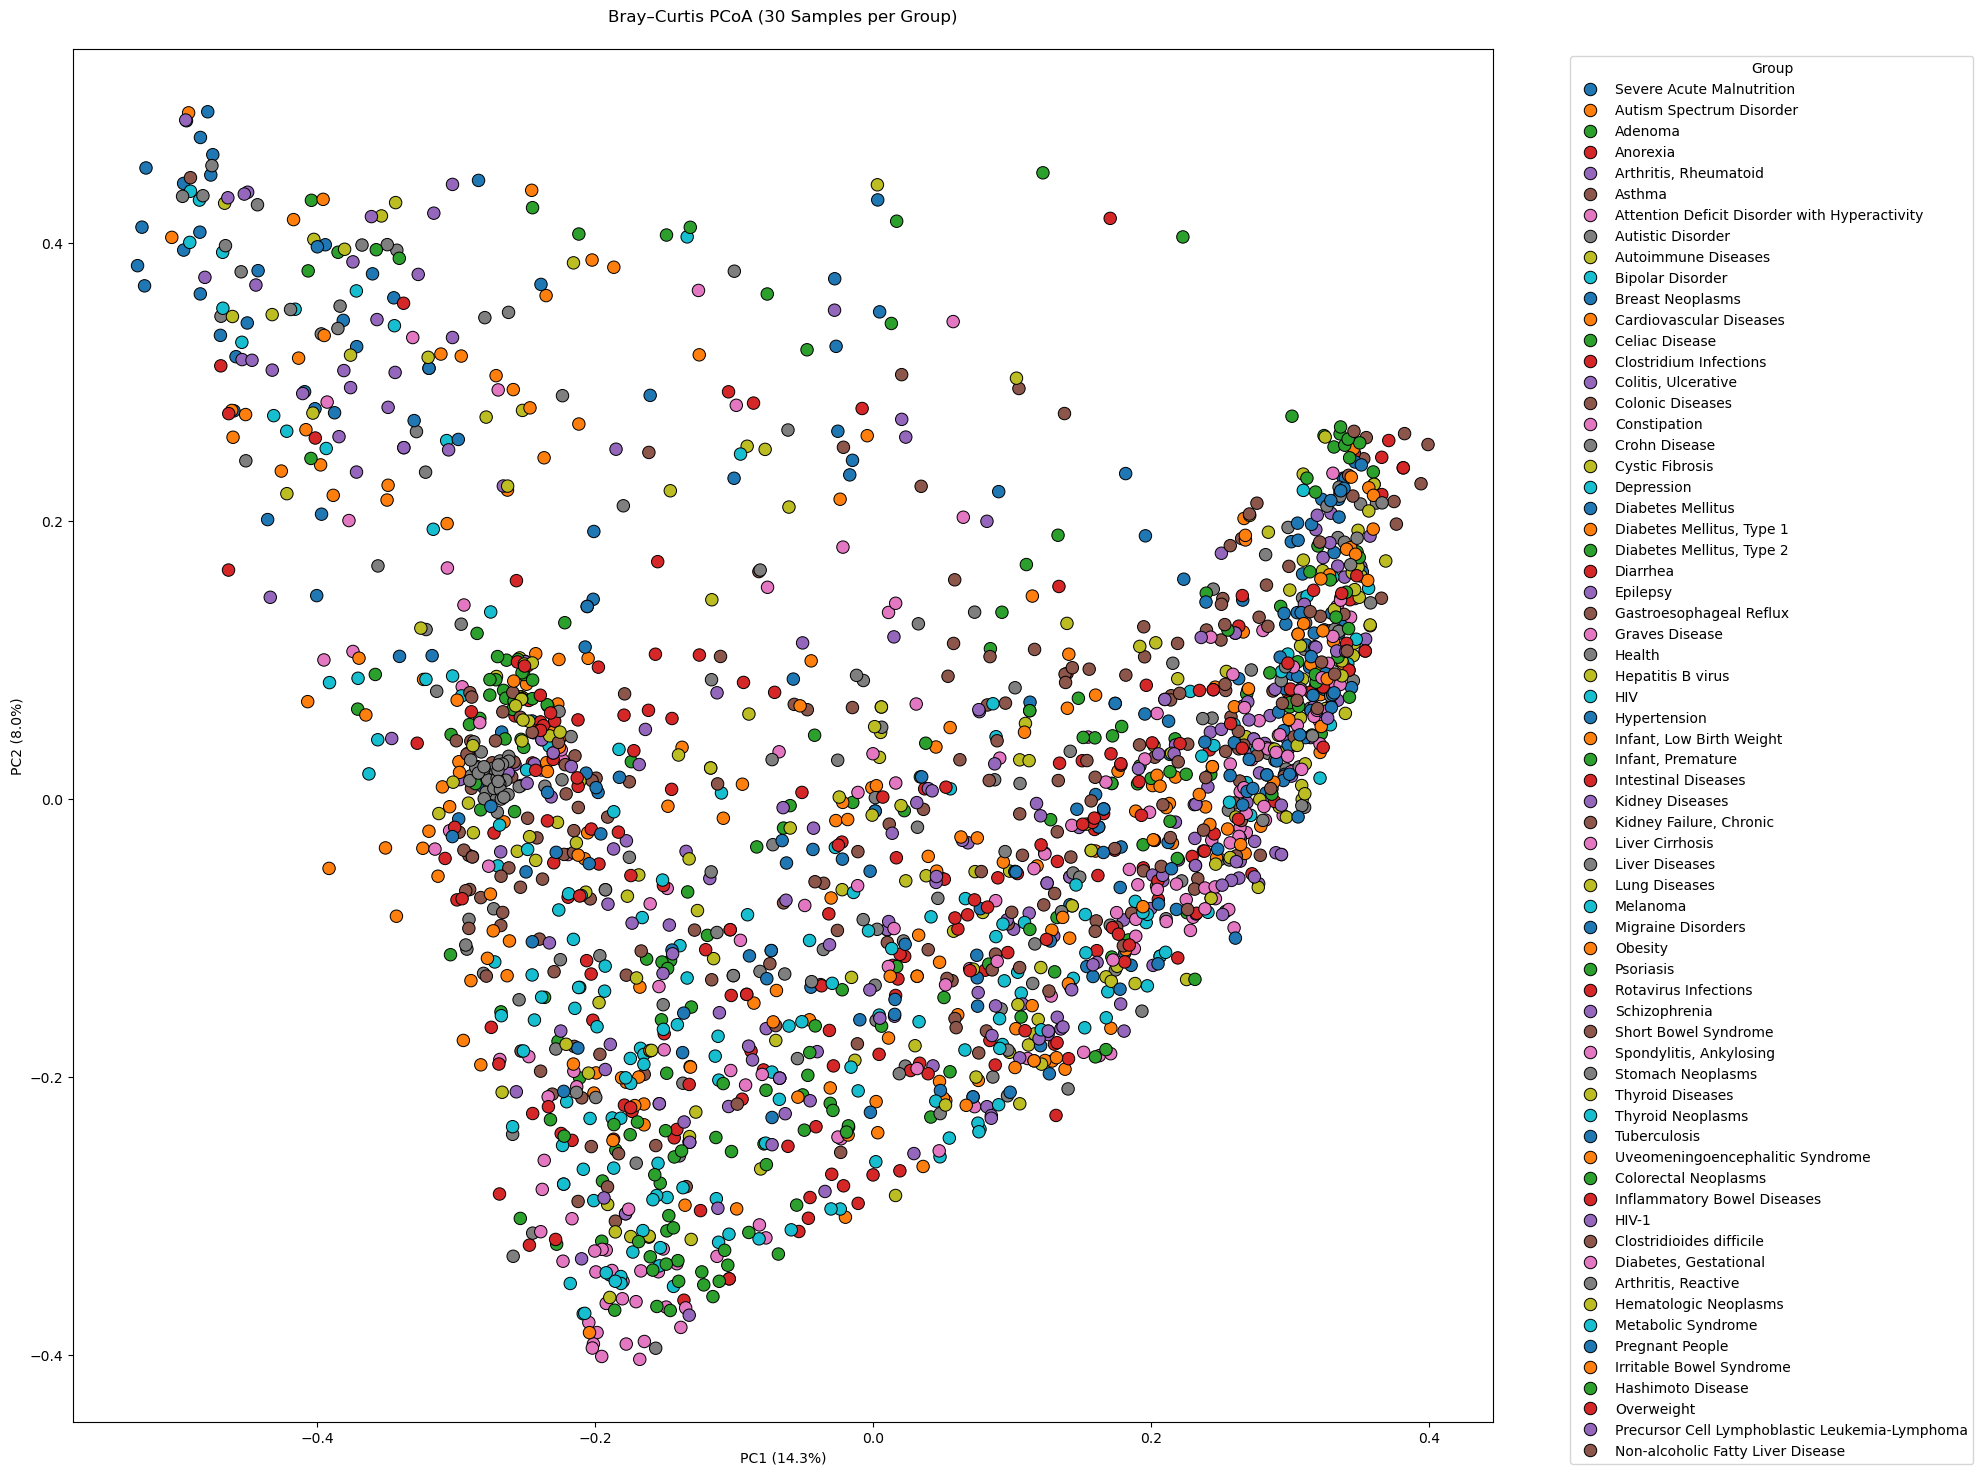

In [ ]:
# ===============================
# STEP 0: Input Assumptions
# -------------------------------
# - genus_index: a MultiIndex (disease, loaded_uid)
# - genus_bc_datamatrix: a square Bray–Curtis NumPy array
# - disease_dict: maps disease codes to readable names
# ===============================

# ---- Create sample labels for DistanceMatrix ----
genus_labels = genus_index.map(lambda x: f"{x[0]}|{x[1]}")

# ---- Build DistanceMatrix for Bray–Curtis ----
genus_dm = DistanceMatrix(genus_bc_datamatrix, ids=genus_labels)

# ---- Metadata DataFrame ----
genus_metadata = pd.DataFrame(
    genus_index.tolist(),
    columns=["disease", "loaded_uid"],
    index=genus_labels
)

# ---- STEP 1: Downsample 30 samples per group ----
n = 30
sampled_ids = []

for group in genus_metadata["disease"].unique():
    group_ids = genus_metadata[genus_metadata["disease"] == group].index.tolist()
    if len(group_ids) >= n:
        sampled_ids.extend(np.random.choice(group_ids, size=n, replace=False))

# ---- STEP 2: Subset Distance Matrix ----
subset_dm = genus_dm.filter(sampled_ids, strict=False)

# ---- STEP 3: Run PCoA ----
pcoa_results = pcoa(subset_dm)
pcoa_df = pcoa_results.samples.copy()

# ---- Add group labels ----
pcoa_df["group"] = genus_metadata.loc[pcoa_df.index, "disease"]
pcoa_df["group_name"] = pcoa_df["group"].map(disease_dict).fillna(pcoa_df["group"])

# ---- STEP 4: Plot PC1 vs PC2 ----
plt.figure(figsize=(20, 35))  # Square canvas

ax = sns.scatterplot(
    data=pcoa_df,
    x=pcoa_df.columns[0],  # PC1
    y=pcoa_df.columns[1],  # PC2
    hue="group_name",
    palette="tab10",
    s=80,
    edgecolor="black"
)

# Force the plot box to be square without altering axis limits
ax.set_aspect('equal', adjustable='box')  # <- ensures same axis length on screen

plt.title("Bray–Curtis PCoA (30 Samples per Group)", pad=20)
plt.xlabel(f"PC1 ({pcoa_results.proportion_explained[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pcoa_results.proportion_explained[1]*100:.1f}%)")
plt.legend(title="Group", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#### <span style="color:teal"> __PCOA SPECIES LEVEL__

In [ ]:
# ===============================
# STEP 0: Input Assumptions
# -------------------------------
# - species_index: a MultiIndex (disease, loaded_uid)
# - species_bc_datamatrix: a square Bray–Curtis NumPy array
# - disease_dict: maps disease codes to readable names
# ===============================

# ---- Create sample labels for DistanceMatrix ----
species_labels = species_index.map(lambda x: f"{x[0]}|{x[1]}")

# ---- Build DistanceMatrix for Bray–Curtis ----
species_dm = DistanceMatrix(species_bc_datamatrix, ids=species_labels)

# ---- Metadata DataFrame ----
species_metadata = pd.DataFrame(
    species_index.tolist(),
    columns=["disease", "loaded_uid"],
    index=species_labels
)

# ---- STEP 1: Downsample 30 samples per group ----
n = 30
sampled_ids = []

for group in species_metadata["disease"].unique():
    group_ids = species_metadata[species_metadata["disease"] == group].index.tolist()
    if len(group_ids) >= n:
        sampled_ids.extend(np.random.choice(group_ids, size=n, replace=False))

# ---- STEP 2: Subset Distance Matrix ----
subset_dm = species_dm.filter(sampled_ids, strict=False)

# ---- STEP 3: Run PCoA ----
pcoa_results = pcoa(subset_dm)
pcoa_df = pcoa_results.samples.copy()

# ---- Add group labels ----
pcoa_df["group"] = species_metadata.loc[pcoa_df.index, "disease"]
pcoa_df["group_name"] = pcoa_df["group"].map(disease_dict).fillna(pcoa_df["group"])

# ---- STEP 4: Plot PC1 vs PC2 ----
plt.figure(figsize=(20, 35))  # Square canvas

ax = sns.scatterplot(
    data=pcoa_df,
    x=pcoa_df.columns[0],  # PC1
    y=pcoa_df.columns[1],  # PC2
    hue="group_name",
    palette="tab10",
    s=80,
    edgecolor="black"
)

# Force the plot box to be square without altering axis limits
ax.set_aspect('equal', adjustable='box')  # <- ensures same axis length on screen

plt.title("Bray–Curtis PCoA (30 Samples per Group)", pad=20)
plt.xlabel(f"PC1 ({pcoa_results.proportion_explained[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pcoa_results.proportion_explained[1]*100:.1f}%)")
plt.legend(title="Group", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()